# Quantum Physics-Informed Neural Networks

## Problem
We want to solve numerically the following spring-mass-damper differential equation:

$$u'' + 5u' + 6u = 10\sin(x)$$

with initial conditions

$$u(0) = 0, \quad u'(0) = 5.$$

The exact solution is given by:

$$u(x) = -6e^{-3x} + 7e^{-2x} + \sin(x) - \cos(x).$$

## Settings

We start by importing the following libraries:

In [1]:
import numpy as np
import tensorflow as tf
import pennylane as qml
import time
import matplotlib.pyplot as plt

In [2]:
from silence_tensorflow import silence_tensorflow

silence_tensorflow() # to remove typcast warnings
tf.keras.backend.set_floatx("float32")
tf.keras.backend.clear_session()

We define the problem domain:

In [3]:
x_0, x_1 = 0.0, 2*np.pi # Interval
nn = 100  # Number of training points
x = np.linspace(x_0, x_1, nn).reshape(-1, 1)  # Column vector of training points
u_0 = tf.constant([[0.0]], dtype=tf.float32)  # Initial condition

## Physics-Informed Loss Function

- The cost function incorporates both the physics (ODE) and boundary conditions (Dirichlet and Neumann BCs) into the training process.
- ODE Loss: The second-order derivative (`u_tt`), first-order derivative (`u_t`), and the function itself (`u`) are calculated to form the ODE residual. 
- The goal is to minimize the difference between this equation and the expected right-hand side ($10 \sin{t}$).
- Boundary Conditions:
	- Dirichlet BC: $u(0) = 0$.
	- Neumann BC: $u'(0) = 5$.

The total loss is the sum of the squared errors from the ODE, the Dirichlet boundary, and the Neumann boundary.

In [4]:
# Exact solution for comparison
def exact_solution(x):
    return -6*np.exp(-3*x) + 7*np.exp(-2*x) + np.sin(x) - np.cos(x)

ua = exact_solution(x)  # Compute analytic solution for the training points

# Define physics-informed loss function
def cost_fn(t, net):
    t = tf.Variable(t, dtype=tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        u = net(t)
        u_t = tape.gradient(u, t)

    u_tt = tape.gradient(u_t, t)
    del tape

    ODE_loss = u_tt + 5 * u_t + 6 * u - 10 * tf.math.sin(t)  # ODE loss
    Left_boundary_loss = net(tf.zeros((1,1))) - u_0  # Dirichlet BC


    with tf.GradientTape() as tape:
        t_zero = tf.zeros((1,1), dtype=tf.float32)
        tape.watch(t_zero)
        u0 = net(t_zero)
        grad_u0 = tape.gradient(u0, t_zero)

    # Neumann BC
    if grad_u0 is not None:
        Neumann_loss = grad_u0 - 5
    else:
        Neumann_loss = tf.constant(0.0, dtype=tf.float32)  # Prevent NoneType errors

    return tf.reduce_mean(tf.square(ODE_loss) + tf.square(Left_boundary_loss) + tf.square(Neumann_loss))


## Implementing the Quantum Neural Network

Now we are ready to implement the quantum neural network:

- `n_qubits`: The number of qubits in the quantum circuit.

- `n_layers`: The number of layers of quantum gates in the quantum circuit.

- `qml.device`: This specifies the quantum device we’re using.

- `@qml.qnode`: This decorator wraps the function `qnode` to make it a quantum node.

- `AngleEmbedding`: Encodes the classical input (inputs) into quantum states. The inputs are converted to quantum bits (qubits).

- `StronglyEntanglingLayers`: A layer of entangling quantum gates applied to the qubits.

- `qml.expval(qml.PauliZ(wires=i))`: Measures the expectation value of the Pauli-Z operator on each qubit. 

- `weight_shapes`: This defines the shapes of the parameters (weights) used in the quantum part of the model.

In [5]:
# QNN architecture
n_qubits = 3 # (3-4 qubits is good)
n_layers = 5 # (5-8 layers is good)  

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method='best')
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

weight_shape = qml.StronglyEntanglingLayers.shape(n_layers, n_qubits)
weight_shapes = {"weights": weight_shape}

We want to visualize the circuit:

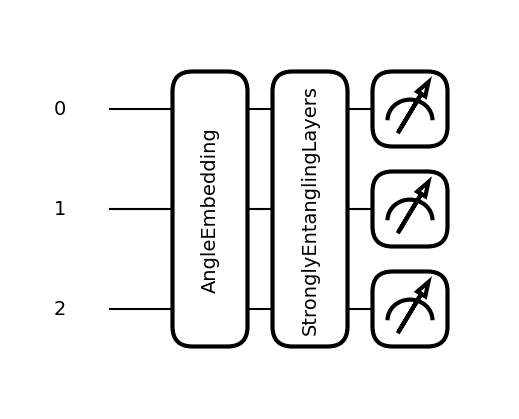

In [6]:
# Random inputs and weights for visualization
inputs = np.array([0.1, 0.2, 0.3])
weights = np.random.randn(n_layers, n_qubits, 3)

# Draw the circuit schematically
fig, ax = qml.draw_mpl(qnode)(inputs, weights)
plt.show()

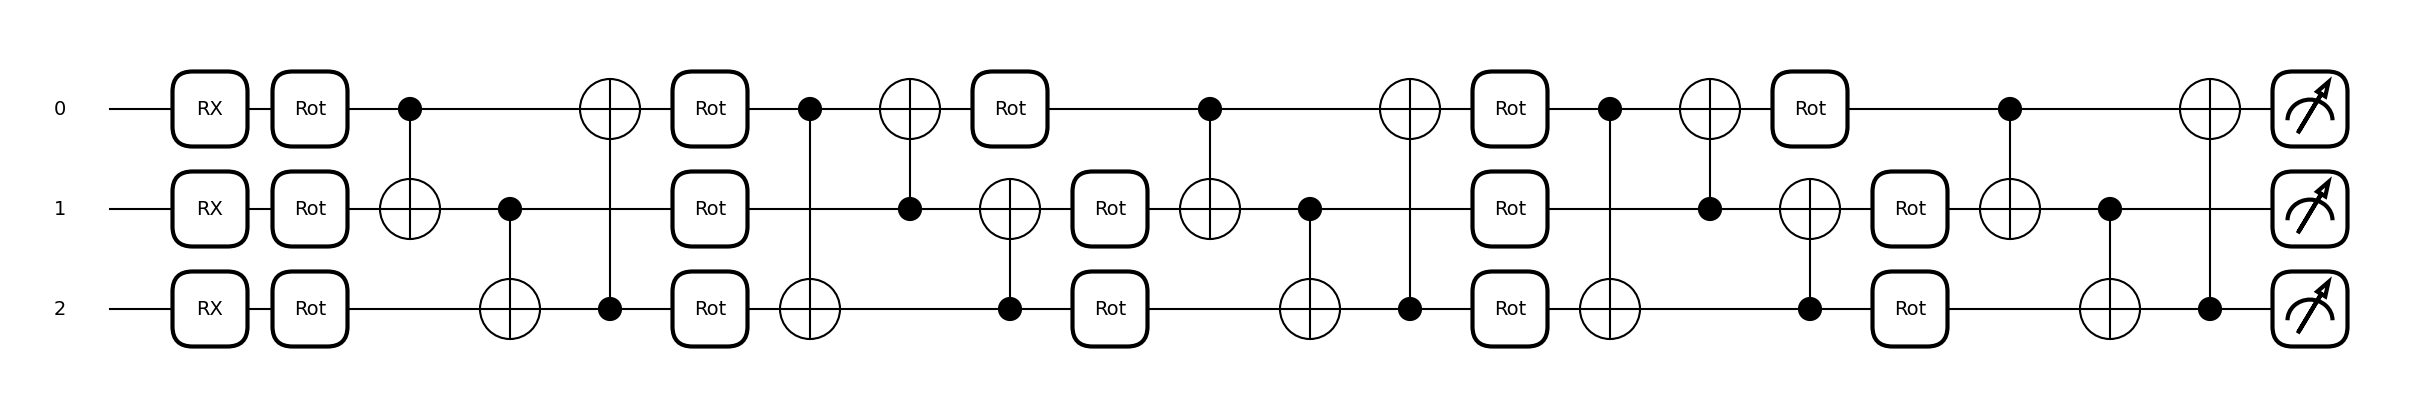

In [7]:
# Draw the circuit at the gate level
qml.draw_mpl(qnode, level="device")(inputs, weights)
plt.show()

## Define the Hybrid QNN model 

We consider a hybrid architecture:

- `NN`: denotes a hybrid classical-quantum neural network model:

    - `tf.keras.layers.Dense(n_qubits, activation="tanh")`: A classical dense layer with `n_qubits` neurons and a $\tanh(x)$ activation.

    - `qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)`: The quantum part of the model, which uses the `qnode` as a quantum layer. This layer connects the classical and quantum parts.
    
    - `tf.keras.layers.Dense(1, activation=None)`: The final dense layer, which outputs a single value. This represents the approximation of the solution $u(x)$.

In [8]:
# Define hybrid QNN model
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(n_qubits, activation="tanh"),
    qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits), 
    tf.keras.layers.Dense(1, activation=None)
])

In [9]:
NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 6         
                                                                 
 keras_layer (KerasLayer)    (None, 3)                 45        
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


Note that `qml.StronglyEntanglingLayers` expects weights of shape `(n_layers, n_qubits, 3)`. That’s:

$$5 \text{ layers } \cdot 3 \text{ qubits } \cdot 3 \text{ rotation gates per qubit } = 45 \text{ parameters}.$$

Each of the 3 parameters per qubit per layer corresponds to a rotation $(R_X, R_Y, R_Z)$.

A pictorial representation of the architecture of the model is given by

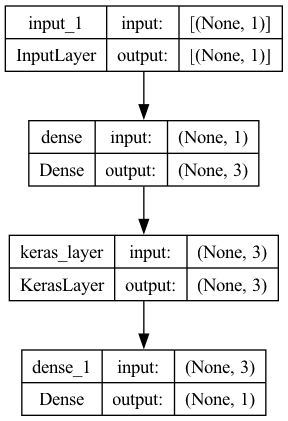

In [10]:
tf.keras.utils.plot_model(
    NN,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
)

## Training the model

Now, let us consider the training step:

- `lr`: The learning rate for the optimizer (Adam).

- `max_iterations`: The number of iterations (steps) for training.

- `Optimizer`: The Adam optimizer is used to update the model’s parameters.

- Training Loop: In each iteration, the `cost_fn` is computed, and gradients are calculated using `GradientTape`. Then the optimizer applies those gradients to update the model’s weights.

- `cost_history`: The loss at each iteration is stored to track the training progress.

In [11]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=500,
    decay_rate=0.9,
    staircase=False
)

max_iterations = 1000
opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
cost_history = []

start_time = time.time()
for itr in range(max_iterations):
    with tf.GradientTape() as tape:
        train_loss = cost_fn(x, NN)
    grads = tape.gradient(train_loss, NN.trainable_variables)
    opt.apply_gradients(zip(grads, NN.trainable_variables))

    cost_history.append(train_loss.numpy())
    if (itr+1) % 50 == 0:
        print(f"Iteration {itr+1}/{max_iterations}, Cost: {train_loss.numpy():.4f}")

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Iteration 50/1000, Cost: 32.1584
Iteration 100/1000, Cost: 12.4950
Iteration 150/1000, Cost: 7.8439
Iteration 200/1000, Cost: 5.3472
Iteration 250/1000, Cost: 4.4042
Iteration 300/1000, Cost: 4.1472
Iteration 350/1000, Cost: 4.0896
Iteration 400/1000, Cost: 4.0762
Iteration 450/1000, Cost: 4.0715
Iteration 500/1000, Cost: 4.0689
Iteration 550/1000, Cost: 4.0679
Iteration 600/1000, Cost: 4.0656
Iteration 650/1000, Cost: 4.0644
Iteration 700/1000, Cost: 4.0634
Iteration 750/1000, Cost: 4.0624
Iteration 800/1000, Cost: 4.0615
Iteration 850/1000, Cost: 4.0643
Iteration 900/1000, Cost: 4.0597
Iteration 950/1000, Cost: 4.0588
Iteration 1000/1000, Cost: 4.0579
Training time: 608.97 seconds


## Evaluation of the model

After training, we are ready to use the model to predict the values of $u(\vec{x})$ for the given $\vec{x}$.

In [12]:
# Evaluate model
u_qml = NN.predict(x).ravel();

# Mean Squared Error
error = np.mean((ua - u_qml) ** 2)
print(f"Mean Squared Error: {error:.6f}")

4/4 [==============================] - 0s 27ms/step
Mean Squared Error: 2.045066


## Results

We are finally able to plot the results:

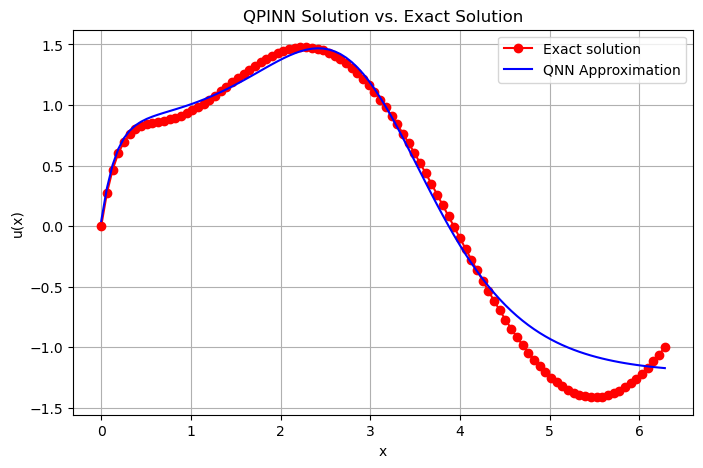

In [13]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(x, ua, 'ro-', label="Exact solution")
plt.plot(x, u_qml, 'b-', label="QNN Approximation")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("QPINN Solution vs. Exact Solution")
plt.grid()
plt.show()